Walmart dataset shape: (6435, 8)
Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


After dropping NaNs, X_w shape: (6435, 6)
       Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price          CPI  \
count  6.435000e+03   6435.000000  6435.000000  6435.000000  6435.000000   
mean   1.046965e+06      0.069930    60.663782     3.358607   171.578394   
std    5.643666e+05      0.255049    18.444933     0.459020    39.356712   
min    2.099862e+05      0.000000    -2.060000     2.472000   126.064000   
25%    5.533501e+05      0.000000    47.460000     2.933000   131.735000   
50%    9.607460e+05      0.000000    62.670000     3.445000   182.616521   
75%    1.420159e+06      0.000000    74.940000     3.735000   212.743293   
max    3.818686e+06      1.000000   100.140000     4.468000   227.232807   

       Unemployment  
count   6435.000000  
mean       7.999151  
std        1.875885  
min        3.879000  
25%        6.891000  
50%        7.874000  
75%        8.622000  
max       14.313000  


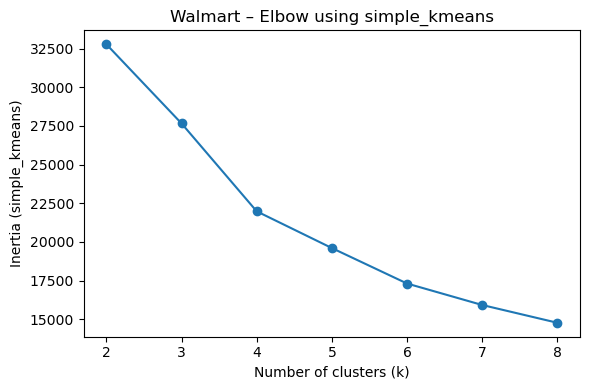

Unique clusters: [0 1 2]
Silhouette (original scaled space): 0.2042064563002735


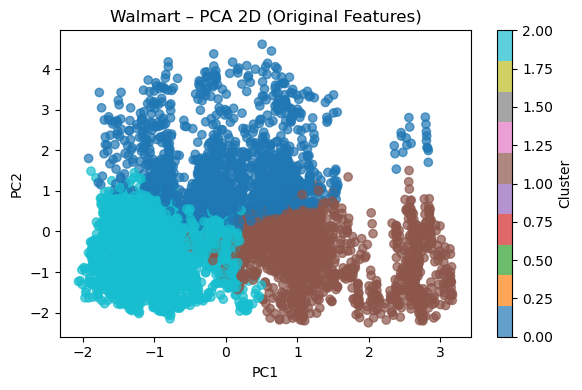

Silhouette (LDA space, same labels): 0.4919105854473974


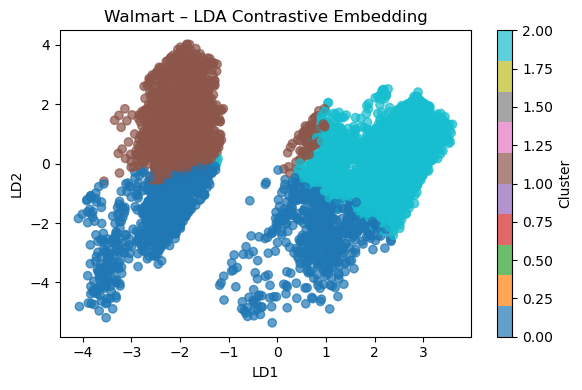

Silhouette (K-Means on LDA embedding): 0.5312180720350407


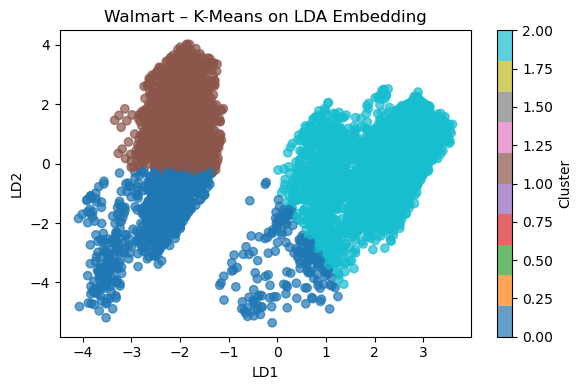

In [1]:
# ==============================
# 1) IMPORTS
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import silhouette_score

# %matplotlib inline   # uncomment in Jupyter if needed


# ==============================
# 2) SIMPLE K-MEANS (NUMPY VERSION)
#    (Skip this if already defined above)
# ==============================
def simple_kmeans(X, n_clusters, n_iters=100, random_state=42):
    """
    Very simple K-Means implementation using NumPy only.
    X: (n_samples, n_features) array
    Returns:
        labels: cluster index for each sample
        centers: cluster centers
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]

    # 1) Initialize centroids by picking random points
    centers = X[rng.choice(n_samples, n_clusters, replace=False)]

    for it in range(n_iters):
        # 2) Assign each point to nearest centroid
        distances = ((X[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
        labels = distances.argmin(axis=1)

        # 3) Recompute centroids
        new_centers = np.zeros_like(centers)
        for k in range(n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centers[k] = cluster_points.mean(axis=0)
            else:
                # If a cluster is empty, reinitialize randomly
                new_centers[k] = X[rng.randint(0, n_samples)]

        # 4) Check convergence
        if np.allclose(new_centers, centers):
            break
        centers = new_centers

    return labels, centers


# ==============================
# 3) LOAD WALMART DATASET
# ==============================
walmart_path = r"C:\Users\70829\Downloads\Mall_Customers_Segmentation_main\Walmart_Sales_Dataset_of_45stores\walmart-sales-dataset-of-45stores.csv"

df_w = pd.read_csv(walmart_path)
print("Walmart dataset shape:", df_w.shape)
print(df_w.columns)
display(df_w.head())


# ==============================
# 4) SELECT NUMERICAL FEATURES
# ==============================
w_cols = ["Weekly_Sales", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]

walmart_data = df_w[w_cols].dropna()
X_w = walmart_data.values   # (n_samples, 6)

print("After dropping NaNs, X_w shape:", X_w.shape)
print(walmart_data.describe())


# ==============================
# 5) SCALE DATA
# ==============================
scaler_w = StandardScaler()
X_w_scaled = scaler_w.fit_transform(X_w)


# ==============================
# 6) (OPTIONAL) ELBOW CHECK WITH simple_kmeans
# ==============================
inertias = []
K_range = range(2, 9)

for k in K_range:
    labels_k, centers_k = simple_kmeans(X_w_scaled, n_clusters=k, n_iters=100, random_state=42)
    distances = ((X_w_scaled - centers_k[labels_k]) ** 2).sum(axis=1)
    inertias.append(distances.sum())

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (simple_kmeans)")
plt.title("Walmart – Elbow using simple_kmeans")
plt.tight_layout()
plt.show()


# ==============================
# 7) RUN simple_kmeans (CHOOSE k)
# ==============================
# From earlier work: k=3 is good
k_w = 3
w_labels, w_centers = simple_kmeans(
    X_w_scaled,
    n_clusters=k_w,
    n_iters=100,
    random_state=42
)

print("Unique clusters:", np.unique(w_labels))
print("Silhouette (original scaled space):",
      silhouette_score(X_w_scaled, w_labels))


# ==============================
# 8) PCA VISUALIZATION (ORIGINAL FEATURES)
# ==============================
pca_w = PCA(n_components=2)
X_w_pca = pca_w.fit_transform(X_w_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_w_pca[:,0], X_w_pca[:,1],
            c=w_labels, cmap='tab10', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("Walmart – PCA 2D (Original Features)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()


# ==============================
# 9) LDA "SIMPLE CONTRASTIVE" EMBEDDING
# ==============================
lda_w = LDA(n_components=2)
X_w_lda = lda_w.fit_transform(X_w_scaled, w_labels)

print("Silhouette (LDA space, same labels):",
      silhouette_score(X_w_lda, w_labels))

plt.figure(figsize=(6,4))
plt.scatter(X_w_lda[:,0], X_w_lda[:,1],
            c=w_labels, cmap='tab10', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("Walmart – LDA Contrastive Embedding")
plt.xlabel("LD1"); plt.ylabel("LD2")
plt.tight_layout()
plt.show()


# ==============================
# 10) K-MEANS AGAIN ON LDA EMBEDDING (OPTIONAL)
# ==============================
w_labels_lda, w_centers_lda = simple_kmeans(
    X_w_lda,
    n_clusters=k_w,
    n_iters=100,
    random_state=42
)

print("Silhouette (K-Means on LDA embedding):",
      silhouette_score(X_w_lda, w_labels_lda))

plt.figure(figsize=(6,4))
plt.scatter(X_w_lda[:,0], X_w_lda[:,1],
            c=w_labels_lda, cmap='tab10', alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("Walmart – K-Means on LDA Embedding")
plt.xlabel("LD1"); plt.ylabel("LD2")
plt.tight_layout()
plt.show()
